# VGGtest

In [ ]:
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from keras import applications
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

datasetpath = r'C:\Users\SurfacePro4\Desktop\dataset'
batch_size = 32
img_size = 128
vggmodel = applications.VGG16(include_top=False, weights='imagenet')

vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.2)

In [34]:
train_generator = vgg_data_gen.flow_from_directory(
        r'C:\Users\SurfacePro4\Desktop\dataset\training',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False)  

val_generator = vgg_data_gen.flow_from_directory(
        r'C:\Users\SurfacePro4\Desktop\dataset\validation',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2197 images belonging to 4 classes.
Found 612 images belonging to 4 classes.


In [35]:
#extract features from train_generator (take quite long time)
X_train = vggmodel.predict_generator(train_generator, len(train_generator))

#save X_train (so we don't need to extract again)
filename = 'cnn_features_training(i128b32)'
with open(filename, 'wb') as f:
          np.save(f, X_train)

In [36]:
#extract features from val set
X_val = vggmodel.predict_generator(val_generator, len(val_generator))
filename = 'cnn_features_validation(i128b32)'
with open(filename, 'wb') as f:
          np.save(f, X_val)

**If you already have cnn_features_training/valid files, you can skip extraction cells (2 cells above)

In [39]:
from keras.utils.np_utils import to_categorical
num_classes = len(train_generator.class_indices)
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(val_generator.filenames)

with open('cnn_features_training(i128b32)', 'rb') as f:
    X_train = np.load(f)
Y_train = train_generator.classes
Y_train = to_categorical(Y_train, num_classes=num_classes)

with open('cnn_features_validation(i128b32)', 'rb') as f:
    X_val = np.load(f)
Y_val = val_generator.classes
Y_val = to_categorical(Y_val, num_classes=num_classes)

In [61]:
Histories = {}
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

for i in range(1,5):
    #top model
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    for j in range(i):
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    
    print("Number of layers: "+str(i))
    History = model.fit(X_train, 
                        Y_train,
                        epochs=50,
                        batch_size=batch_size,
                        validation_data=(X_val, Y_val),
                        callbacks=[early_stopping]
                        )
    Histories[i]=History

Number of layers: 1
Train on 2197 samples, validate on 612 samples
Epoch 1/50
2197/2197 [==============================] - 4s 2ms/step - loss: 5.5632 - acc: 0.6245 - val_loss: 3.3518 - val_acc: 0.7712
Epoch 2/50
2197/2197 [==============================] - 3s 2ms/step - loss: 3.7826 - acc: 0.7442 - val_loss: 4.1659 - val_acc: 0.7190
Epoch 3/50
2197/2197 [==============================] - 3s 2ms/step - loss: 3.2662 - acc: 0.7852 - val_loss: 2.8857 - val_acc: 0.8039
Epoch 4/50
2197/2197 [==============================] - 3s 2ms/step - loss: 3.2038 - acc: 0.7893 - val_loss: 2.7241 - val_acc: 0.8203
Epoch 5/50
2197/2197 [==============================] - 3s 2ms/step - loss: 2.8368 - acc: 0.8111 - val_loss: 2.5758 - val_acc: 0.8301
Epoch 6/50
2197/2197 [==============================] - 3s 2ms/step - loss: 2.8618 - acc: 0.8125 - val_loss: 2.8574 - val_acc: 0.8154
Epoch 7/50
2197/2197 [==============================] - 3s 2ms/step - loss: 2.3718 - acc: 0.8439 - val_loss: 2.8178 - val_acc: 0.

2197/2197 [==============================] - 4s 2ms/step - loss: 5.6576 - acc: 0.6450 - val_loss: 3.7613 - val_acc: 0.7614
Epoch 11/50
2197/2197 [==============================] - 4s 2ms/step - loss: 5.5743 - acc: 0.6523 - val_loss: 6.6546 - val_acc: 0.5850
Epoch 12/50
2197/2197 [==============================] - 4s 2ms/step - loss: 6.5477 - acc: 0.5904 - val_loss: 4.6766 - val_acc: 0.7059
Epoch 13/50
2197/2197 [==============================] - 4s 2ms/step - loss: 5.6436 - acc: 0.6450 - val_loss: 6.4531 - val_acc: 0.5964
Epoch 14/50
2197/2197 [==============================] - 4s 2ms/step - loss: 6.1527 - acc: 0.6154 - val_loss: 4.9629 - val_acc: 0.6863
Epoch 15/50
2197/2197 [==============================] - 4s 2ms/step - loss: 5.4674 - acc: 0.6550 - val_loss: 5.3890 - val_acc: 0.6618
Epoch 16/50
2197/2197 [==============================] - 4s 2ms/step - loss: 6.8358 - acc: 0.5740 - val_loss: 5.7414 - val_acc: 0.6438
Epoch 17/50
2197/2197 [==============================] - 4s 2ms/ste

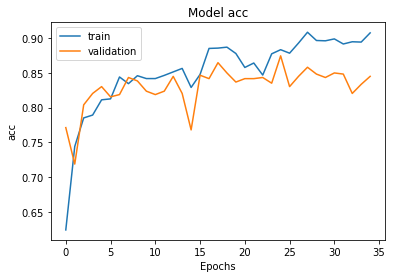

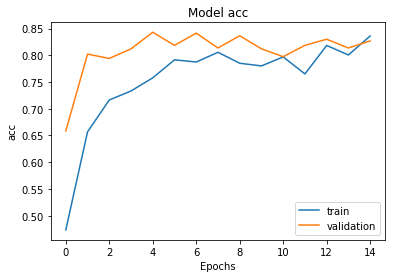

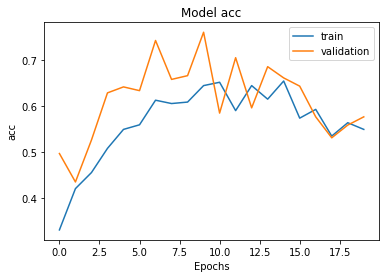

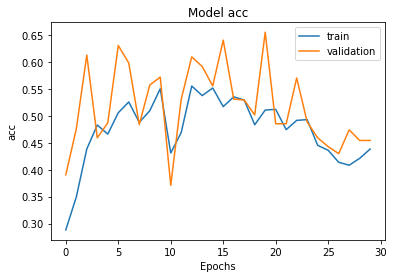

In [63]:
import matplotlib.pyplot as plt
def draw_graph(History, arg): #arg = acc|loss
#     plt.tight_layout()
    plt.plot(History.history[arg])
    val_arg = 'val_' + arg
    plt.plot(History.history[val_arg])
    plt.title('Model '+ arg)
    plt.ylabel(arg)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    plt.show()
    
for i in range(1,5):
    draw_graph(Histories[i],'acc')

In [ ]:
# #test on test set
# test_generator = vgg_data_gen.flow_from_directory(
#         r'C:\Users\SurfacePro4\Desktop\dataset\testing',
#         target_size=(img_size, img_size),
# #         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=False)
# cnn_features = model.predict_generator(val_generator, len(val_generator))

In [ ]:
# from sklearn.metrics import confusion_matrix

# def create_cm_for_test(testdatapath = r'C:\Users\SurfacePro4\Desktop\dataset\testing', img_size = 128):
#     datagen = ImageDataGenerator(rescale = 1./255)
#     test_generator = datagen.flow_from_directory(testdatapath,
#                                             target_size = (img_size, img_size),
#                                             class_mode = 'categorical',
#                                             shuffle = False
#                                             )
#     Y_pred = model.predict_generator(test_generator, len(test_generator))
#     y_pred = np.argmax(Y_pred, axis=1)
#     cm = confusion_matrix(test_generator.classes, y_pred)
#     plot_confusion_matrix(cm, test_generator.class_indices)
    
# create_cm_for_test()